In [15]:
import scanpy as sc
import pandas as pd
import numpy as np
from kneed import KneeLocator

### Performing basic preprocessing of scRNA-seq data

In [8]:
adata = sc.read(filename = "/home/barroz/projects/Columbia/STAT_ML_GEN/project/codex_codex_cn_tumor.h5ad")
adata

AnnData object with n_obs × n_vars = 1984127 × 30
    obs: 'orig.ident', 'nCount_CODEX', 'nFeature_CODEX', 'cell_id', 'Image', 'x_um', 'y_um', 'cell_type', 'day', 'condition', 'neighborhood'
    var: 'gene'
    obsm: 'spatial'
    layers: 'counts', 'normalized_data'

/tmp/ipykernel_12577/3387747014.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  first_img_adata.obs['neighborhood'] = first_img_adata.obs['neighborhood'].astype('category')


<Axes: title={'center': 'neighborhood'}, xlabel='x_um', ylabel='y_um'>

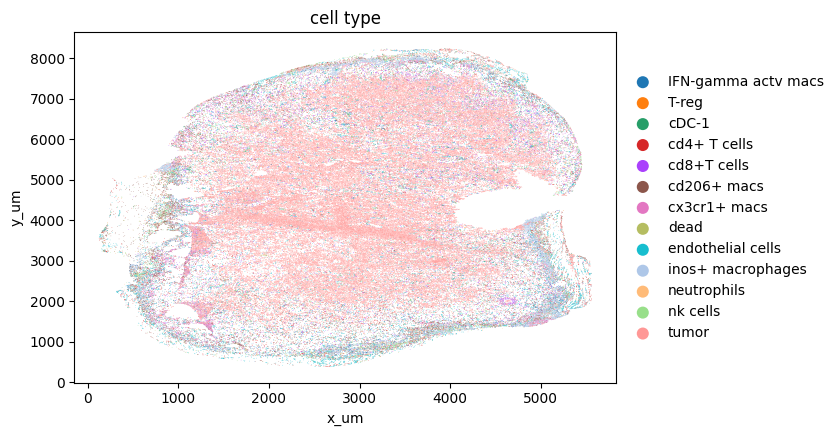

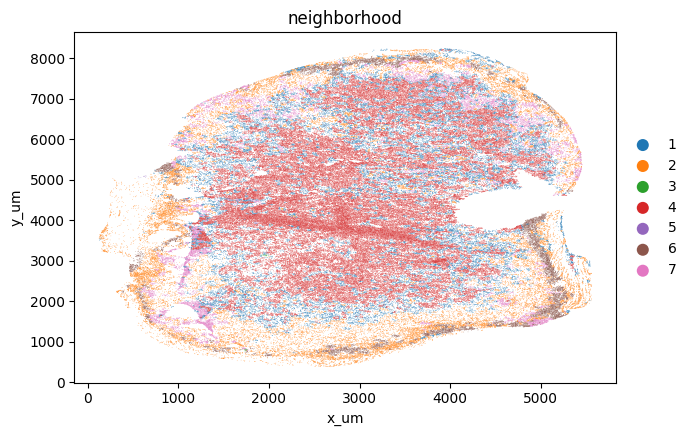

In [27]:
# showing the spatial image and CN for the first Image
image_to_show = adata.obs['Image'].iloc[0]
first_img_adata =adata[adata.obs['Image'] == adata.obs['Image'].iloc[0]]
first_img_adata.obs['neighborhood'] = first_img_adata.obs['neighborhood'].astype('category')
sc.pl.scatter(first_img_adata, show=False, color='cell_type',x='x_um', y='y_um')
sc.pl.scatter(first_img_adata, show=False, color='neighborhood',x='x_um', y='y_um')

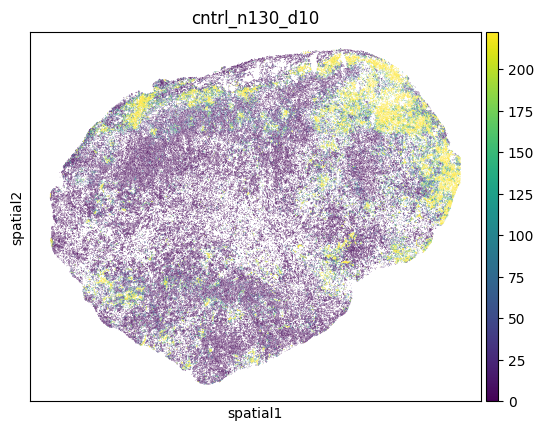

In [53]:
sc.pl.embedding(adata[adata.obs['Image'] == 'cntrl_n130_d10'], color='pdL1', layer='counts',
                basis = 'spatial', title='cntrl_n130_d10', use_raw = False, vmax='p90')


In [ ]:
# run PCA on the data
sc.pp.pca(adata, n_comps=20) 
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(adata) 

Variance captured by 20 PCs: 0.9531202624796836


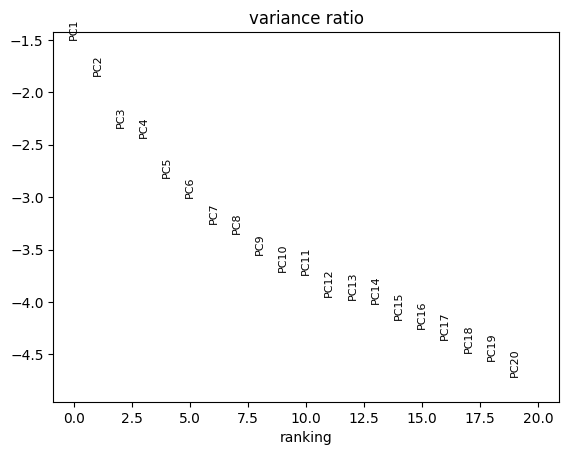

In [60]:
variance_captured  = adata.uns['pca']['variance_ratio'].sum()
print(f'Variance captured by 20 PCs: {variance_captured}')
sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True) # choose 20 like in Seurat tutorial? Or 10 where elbow is


In [63]:
sc.pl.umap(adata,
          color=["Image", "Image", "cell_type", "cell_type", "condition", "condition"],
          dimensions=[(0, 1), (2, 3), (0, 1), (2, 3), (0, 1), (2, 3)],
          ncols=2, size=2, )

# sc.pl.umap(codex, color=['Image'])
# sc.pl.umap(codex, color=['cell_type'])
# sc.pl.umap(codex, color=['condition'], legend_loc='on data')


KeyError: "Could not find 'tsne' or 'X_tsne' in .obsm"

In [58]:
# following contact tracing tutorial
adata.obs.index.name=None
adata.var.index.name=None

In [10]:
# making sure cell barcodes are unique
numdup = sum(adata.obs.index.duplicated())
print(f'{numdup} duplicated barcodes')
if numdup > 0:
    adata.obs_names_make_unique()
    numdup = sum(adata.obs.index.duplicated())
    print(f'Now, {numdup} duplicated barcodes')

0 duplicated barcodes


In [11]:
adata.obs

,orig.ident,nCount_CODEX,nFeature_CODEX,cell_id,Image,x_um,y_um,cell_type,day,condition,neighborhood
2,Longitudinal_Analysis,5542.5302,29,2,cntrl_n109_d10,2667.6,386.38,cd4+ T cells,10,CONTROL,2
4,Longitudinal_Analysis,5318.7952,30,4,cntrl_n109_d10,2634.1,386.83,cd4+ T cells,10,CONTROL,2
5,Longitudinal_Analysis,4478.8312,30,5,cntrl_n109_d10,2656.8,387.74,cd4+ T cells,10,CONTROL,2
6,Longitudinal_Analysis,17031.5743,30,6,cntrl_n109_d10,2571.1,388.36,dead,10,CONTROL,2
7,Longitudinal_Analysis,6466.7471,30,7,cntrl_n109_d10,2642.2,388.94,cd4+ T cells,10,CONTROL,2
...,...,...,...,...,...,...,...,...,...,...,...
3379670,Longitudinal_Analysis,22617.5255,30,154511,ict_n55_d10,1734.6,3537.50,tumor,10,ICT,1
3379671,Longitudinal_Analysis,30698.8812,30,154512,ict_n55_d10,1702.3,3537.90,tumor,10,ICT,1
3379673,Longitudinal_Analysis,21272.8750,30,154514,ict_n55_d10,1713.2,3539.90,nk cells,10,ICT,1
3379674,Longitudinal_Analysis,39985.1071,30,154515,ict_n55_d10,1753.6,3540.70,tumor,10,ICT,1


In [6]:
# condition setting
adata.obs['Condition'] = adata.obs['Sample']

KeyError: 'Sample'

In [8]:
adata.obs['cell type'] = adata.obs['new_annotation']

In [9]:
adata.obs['Condition'].value_counts()

Condition
aPD1_aCTLA4    2939
Control        2607
Name: count, dtype: int64

In [10]:
# removing small cell types
minCell = 50
ctcounts = adata.obs[['cell type','Condition']].value_counts()
remove_cellTypes = ctcounts[ctcounts < minCell].reset_index()['cell type'].unique()
if len(remove_cellTypes) > 0:
    tmpstr = ','.join(remove_cellTypes)
    print(f'Removing celltypes: {tmpstr}')
    print(f'Original ncell {adata.shape[0]}')
    adata = adata[~adata.obs['cell type'].isin(remove_cellTypes)]
    print(f'New ncell {adata.shape[0]}')
else:
    print('Keeping all cell types')

Keeping all cell types


In [11]:
# creating logX layer
adata.X = adata.X.toarray()
adata.layers['logX'] = np.log10(adata.X + 0.1) - np.log10(0.1)

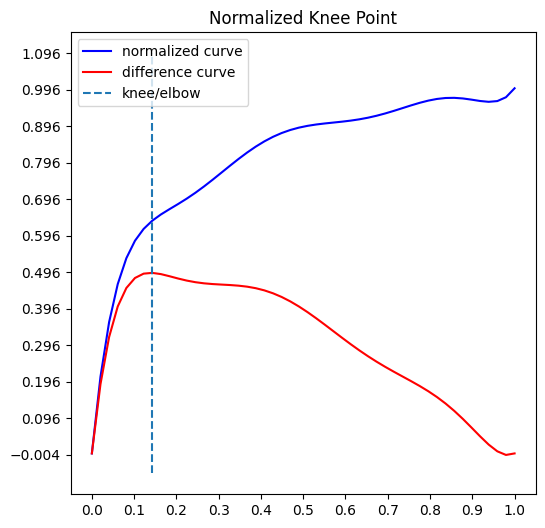

In [12]:

# use kneepoint method to get number of PCs to use
init_npcs = 50
scanpy.pp.pca(adata, n_comps=init_npcs)
x = [x for x in range(len(adata.uns['pca']['variance_ratio']))]
y = np.log(adata.uns['pca']['variance_ratio'])
knee = KneeLocator(x=x, y=y, curve='convex', direction='decreasing', online=True, interp_method='polynomial')
knee.plot_knee_normalized()

In [13]:
opt_n_pcs = knee.knee+1
print('Optimal Number of PCs: ', str(opt_n_pcs))
scanpy.pp.pca(adata, n_comps=opt_n_pcs)
scanpy.pp.neighbors(adata)
scanpy.tl.umap(adata)

Optimal Number of PCs:  8


/Users/nicholasdjedjos/.pyenv/versions/3.9.7/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


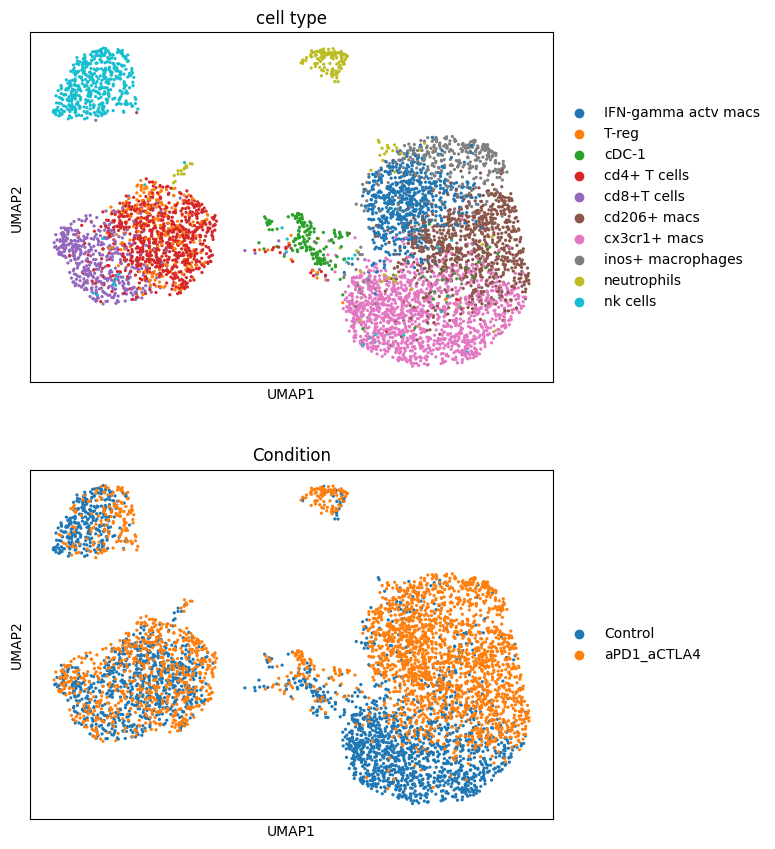

In [15]:
scanpy.pl.umap(adata, color=['cell type', 'Condition'], ncols=1)
